# KNNs and Decision Trees
In this notebook, we will examine a new classification problem using two new techniques: $k$-Nearest Neighbors and Decision Trees.

**Learning Outcomes**

1. Describe how a data set is used to compute classifications on unseen data using a $k$-Nearest Neighbors classifier
2. Implement classification models from the `scikit-learn` package
3. Describe how a decision tree classifier is constructed and identify its parameters

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cs171lecture42 as l42
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Yet Another Classification Problem
When oceanographers investigate the global-scale circulation in the ocean, the often *water masses* distinguished by different temperatures, salinities, and therefore densities. For example, consider thr following transect through the middle of the Atlantic Ocean going from the south pole on the left to the north pole on the right:

In [2]:
latitude, Z, depth, theta_grid, salt_grid = l42.read_ocean_transects()

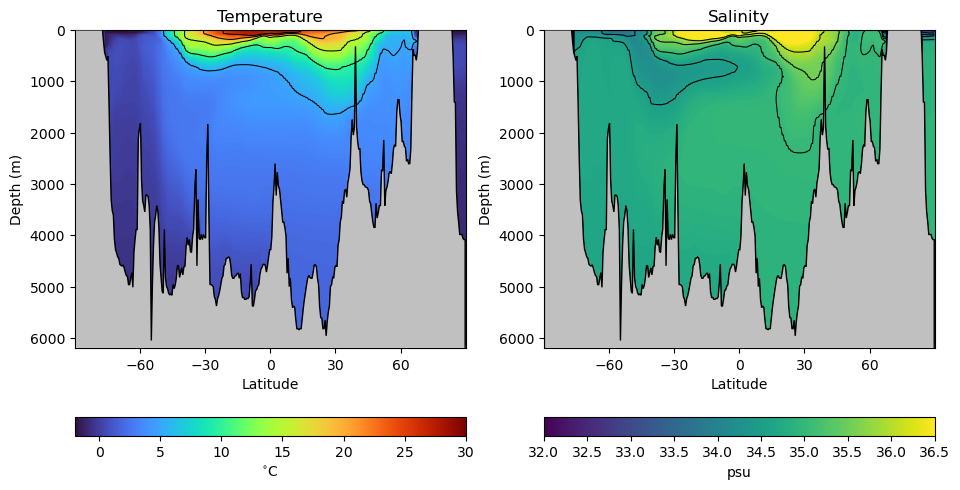

In [3]:
l42.plot_crosssection(latitude, Z, depth, theta_grid, salt_grid)

As we can see, there are variations in ocean temperature and salinity in both the vertical and latitudinal directions. But how are these water masses connected? We can get a sense by looking at different classifications of these properties based on samples from the real ocean. Let's read in a data set with different water masses:

In [4]:
df = pd.read_csv('water_mass_samples.csv')
df

,WaterMass,Temperature_C,Salinity_PSU,WaterMass_LongName
0,NACW,12.132907,35.744703,North Atlantic Central Water
1,NACW,15.156927,35.853817,North Atlantic Central Water
2,NACW,13.405698,35.856125,North Atlantic Central Water
3,NACW,12.495253,35.909970,North Atlantic Central Water
4,NACW,14.850959,35.721954,North Atlantic Central Water
...,...,...,...,...
195,PDW,1.809358,34.647847,Pacific Deep Water
196,PDW,1.434369,34.661971,Pacific Deep Water
197,PDW,1.522158,34.653880,Pacific Deep Water
198,PDW,1.507240,34.637925,Pacific Deep Water


In the data set above, each row in the data frame has a temperature and salinity value as well as a corresponding classification of its water mass - in other words, which waters it was sampled from. Unlike the previous binary classifications, there are more than just 2 classifications here. Let's see how many classifications there are:

In [6]:
watermasses = df["WaterMass"].unique()
watermasses

array(['NACW', 'SACW', 'AAIW', 'MOW', 'NADW', 'AABW', 'NPCW', 'SPCW',
       'NPIW', 'PDW'], dtype=object)

In [7]:
watermasses_long = df["WaterMass_LongName"].unique()
watermasses_long

array(['North Atlantic Central Water', 'South Atlantic Central Water',
       'Antarctic Intermediate Water', 'Mediterranean Outflow Water',
       'North Atlantic Deep Water', 'Antarctic Bottom Water',
       'North Pacific Central Water', 'South Pacific Central Water',
       'North Pacific Intermediate Water', 'Pacific Deep Water'],
      dtype=object)

That's 10 different water masses in our dataset! 

Just like our previous examples, we'll need to encode a classification number for each one - a number 0-9 that maps the classification name to an integer we can use in computations. Let's do that below:

In [12]:
mass_to_number = {}
for i in range(len(watermasses)):
    mass_to_number[watermasses[i]] = i
print(mass_to_number)

# Create the new column using map
df['WaterMassIndex'] = df['WaterMass'].map(mass_to_number)

{'NACW': 0, 'SACW': 1, 'AAIW': 2, 'MOW': 3, 'NADW': 4, 'AABW': 5, 'NPCW': 6, 'SPCW': 7, 'NPIW': 8, 'PDW': 9}


We can check the header and footer of our data frame to ensure this indexing was assigned appropriately:

In [13]:
df.head()

,WaterMass,Temperature_C,Salinity_PSU,WaterMass_LongName,WaterMassIndex
0,NACW,12.132907,35.744703,North Atlantic Central Water,0
1,NACW,15.156927,35.853817,North Atlantic Central Water,0
2,NACW,13.405698,35.856125,North Atlantic Central Water,0
3,NACW,12.495253,35.909970,North Atlantic Central Water,0
4,NACW,14.850959,35.721954,North Atlantic Central Water,0


In [14]:
df.tail()

,WaterMass,Temperature_C,Salinity_PSU,WaterMass_LongName,WaterMassIndex
195,PDW,1.809358,34.647847,Pacific Deep Water,9
196,PDW,1.434369,34.661971,Pacific Deep Water,9
197,PDW,1.522158,34.653880,Pacific Deep Water,9
198,PDW,1.507240,34.637925,Pacific Deep Water,9
199,PDW,1.576270,34.666684,Pacific Deep Water,9


So far so good! Since we're going to be plotting the same dataset a few times, let's define a common set of bounds for our axes:

In [15]:
# define some bounds to be used in the plots below
min_S = 33.8
max_S = 37.2
min_T = -1
max_T = 18

Next, let's plot the data on a temperature-salinity diagram - an oceanographer's favorite diagram:

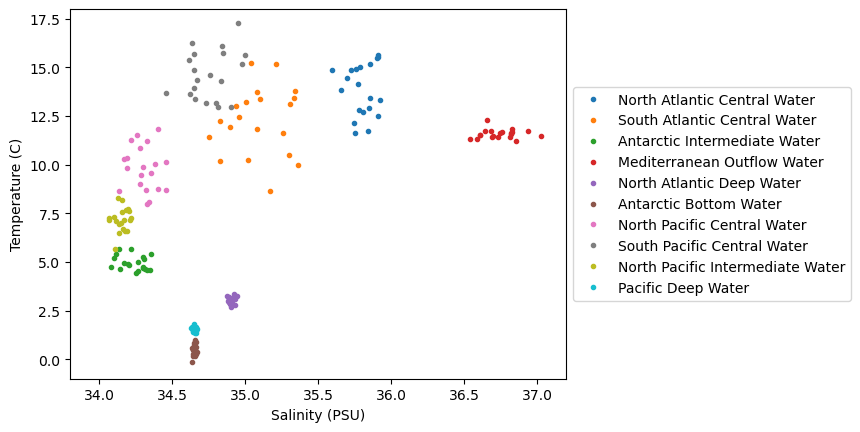

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for w, watermass, in enumerate(watermasses):
    plt.plot(df[df['WaterMass']==watermass]['Salinity_PSU'],
             df[df['WaterMass']==watermass]['Temperature_C'],
             '.', label=watermasses_long[w], color=colors[w])
plt.gca().set_xlim([min_S,max_S])
plt.gca().set_ylim([min_T,max_T])
plt.ylabel('Temperature (C)')
plt.xlabel('Salinity (PSU)')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We can see in this dataset that there is are some clusters of points in these diagrams, but they are not all unique - there are some overlapping sections. Let's see how we can go about classifying various parts of this diagram, even for unknown regions. 

## $k$-Nearest Neighbors

The first example we'll look at is the $k$-Nearest Neighbors classifier, or KNN for short. The KNN classifier is pretty simple, and the rules are as follows:

For a given point in the parameter space (i.e. given a temperature and salinity value),
1. Find the $k$ "closest" points
2. Find the most common classification for the $k$ closest points
3. Assign the classification to the new point

Let's see how we can code that up into a class like our previous examples:

In [46]:
import numpy as np

class KNN:
    """
    An implementation of the k-Nearest Neighbors (kNN) classifier using NumPy.
    """

    def __init__(self, X_train, c_train, k):
        """
        Initializes the KNN classifier.
        """
        self.X_train = X_train
        self.c_train = c_train
        self.k       = k

    def predict(self, X_test):
        """
        Predicts the labels for the test data.
        """
        return np.array([self.classify(x) for x in X_test])

    def classify(self, x):
        """
        Predict the label for a single test sample.
        """
        distances = np.linalg.norm(self.X_train - x, axis = 1)
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.c_train[k_indices]

        labels, counts = np.unique(k_nearest_labels, return_counts = True)
        final_label = labels[np.argmax(counts)]

        return(final_label)

Let's see how the results look for our water mass data

In [47]:
# initialize the data arrays
X = df[['Salinity_PSU', 'Temperature_C']]
c = df['WaterMassIndex']

# create the knn object
knn = KNN(X, c, k = 3)

Now, use the `predict` method to apply the model to a range of points in the temperature-salinity space:

In [48]:
# make a range of points in the space
salinity = np.linspace(min_S, max_S, 100)
temperature = np.linspace(min_T, max_T, 100)
Salinity, Temperature = np.meshgrid(salinity, temperature)
                          
# apply the model
X_test = np.column_stack([Salinity.ravel(), Temperature.ravel()])
WaterMassIndices = knn.predict(X_test)
WaterMassIndices = np.reshape(WaterMassIndices, np.shape(Salinity))

Let's plot the model classifications along with our data to see how things look:

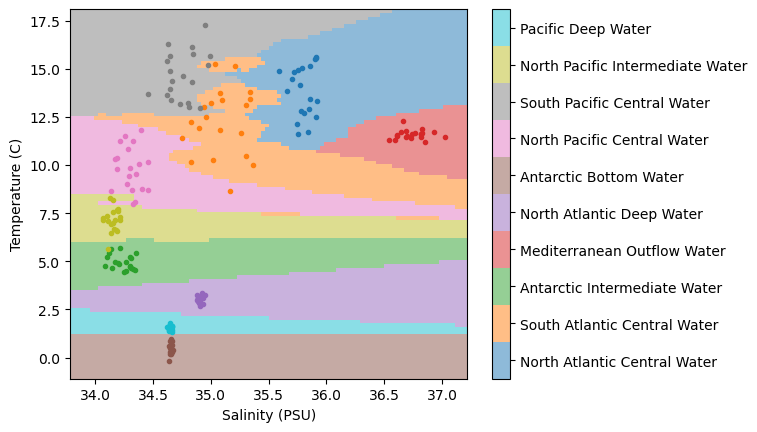

In [49]:
# plot the model classifications
C = plt.pcolormesh(Salinity, Temperature, WaterMassIndices, cmap='tab10',
                   alpha=0.5, vmin=0, vmax=len(watermasses_long))
cbar = plt.colorbar(C, ticks=np.arange(len(watermasses_long))+0.5)
cbar.set_ticklabels(watermasses_long)

# plot the data
for w, watermass, in enumerate(watermasses):
    plt.plot(df[df['WaterMass']==watermass]['Salinity_PSU'],
             df[df['WaterMass']==watermass]['Temperature_C'],
             '.', label=watermass, color=colors[w])

plt.ylabel('Temperature (C)')
plt.xlabel('Salinity (PSU)')
plt.show()

Not too bad... we have regions of similar classifications around clusters of points. But we also have some "streaks", particularly in the region in the lower right-hand side of the plot. What's causing those?

It turns out, those streaks are the result of the distance formula used when computing the "closest" points. The distance formula used is the Euclidean distance - the one we learn as the "Pythagorean Theorem" in school. And the thing about the Euclidean distance is that it assumes the magnitude of the data is the same. However, if we take a look at the plot, that's not the case - the temperature range is much larger than the salinity range!

Again, we need to standarize our data - let's apply our usual transformations and try out model again:

In [58]:
# standardize the data
salt_normalized = (df['Salinity_PSU'] - min_S) / (max_S - min_S)
temp_normalized = (df['Temperature_C'] - min_T) / (max_T - min_T)

# recreate the input data
x = np.column_stack([salt_normalized, temp_normalized])
c = df['WaterMassIndex']

# initialize a model to the new data
knn = KNN(X, c, k = 3)

Now, just as before, let's see how our model performs in the entire (normalized) temperature-salinity space:

In [59]:
salinity_norm = (np.linspace(min_S,max_S,100)-min_S)/(max_S-min_S)
temperature_norm = (np.linspace(min_T,max_T,100)-min_T)/(max_T-min_T)
Salinity_norm,Temperature_norm = np.meshgrid(salinity_norm ,temperature_norm)
WaterMassIndices = knn.predict(np.column_stack([Salinity_norm.ravel(),Temperature_norm.ravel()]))
WaterMassIndices = WaterMassIndices.reshape(np.shape(Salinity_norm))

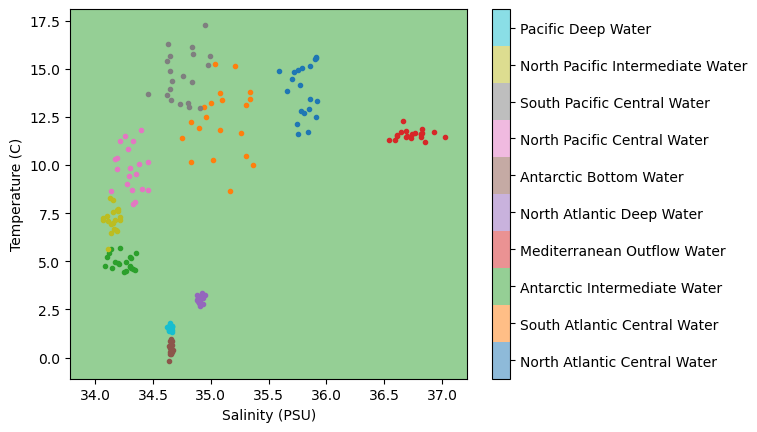

In [60]:
C = plt.pcolormesh(Salinity, Temperature, WaterMassIndices, cmap='tab10',
                   alpha=0.5, vmin=0, vmax=len(watermasses_long))
cbar = plt.colorbar(C, ticks=np.arange(len(watermasses_long))+0.5)
cbar.set_ticklabels(watermasses_long)
for w, watermass, in enumerate(watermasses):
    plt.plot(df[df['WaterMass']==watermass]['Salinity_PSU'],
             df[df['WaterMass']==watermass]['Temperature_C'],
             '.', label=watermass, color=colors[w])
plt.ylabel('Temperature (C)')
plt.xlabel('Salinity (PSU)')
plt.show()

Wow, much different than before!

## Introducing scikit-learn

So far, we have been coding everything from scratch in Python. The benefit of coding from scratch is that we can see what is going on under the hood in our models. However, this tends to slow things down. Luckily, people have worked to generalize all of this code into a framework. In this notebook, we'll rely on tools provided in the `scikit-learn` package.

In [61]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [62]:
knn.fit(X, c)
WaterMassIndices = knn.predict(np.column_stack([Salinity_norm.ravel(),Temperature_norm.ravel()]))
WaterMassIndices = WaterMassIndices.reshape(np.shape(Salinity_norm))

C:\Users\Laser\miniconda3\envs\cs171\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


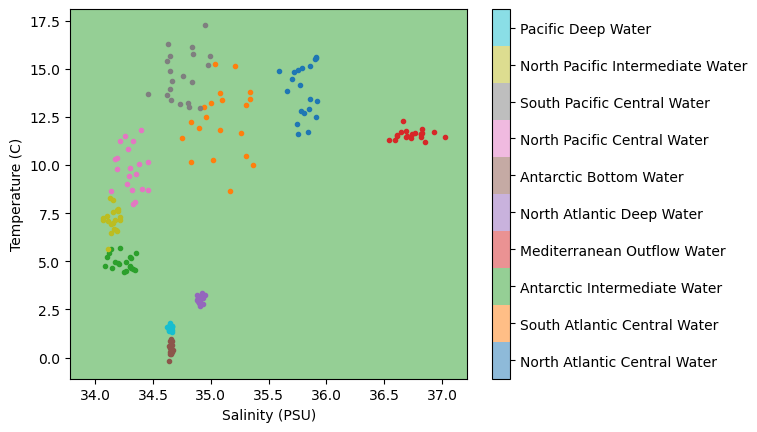

In [63]:
C = plt.pcolormesh(Salinity, Temperature, WaterMassIndices, cmap='tab10',
                   alpha=0.5, vmin=0, vmax=len(watermasses_long))
cbar = plt.colorbar(C, ticks=np.arange(len(watermasses_long))+0.5)
cbar.set_ticklabels(watermasses_long)
for w, watermass, in enumerate(watermasses):
    plt.plot(df[df['WaterMass']==watermass]['Salinity_PSU'],
             df[df['WaterMass']==watermass]['Temperature_C'],
             '.', label=watermass, color=colors[w])
plt.ylabel('Temperature (C)')
plt.xlabel('Salinity (PSU)')
plt.show()

As we can see, `scikit-learn` returns the same classifications as our own, self-written KNN model - a good sanity check! Let's see what other goodies `scikit-learn` has in store to help us with this classification problem.

## Decision Trees

The next classifier we'll look at is a *Decision Tree*. To consider how a desision tree works, let's consider differentiating some water masses using a simple rule. In the above diagram, we can see that one distinguishing feature of the Mediterranean Outflow Water (MOW) is that the salinity is above 36.25 psu. We can use this attribute to set up a simple classification according to the following diagram:

<img src="Decision_Tree_Schematic_1layer.png" alt="Schematic of a 1-layer Decision Tree" width="500">

This simple classification allows us to distinguish between two different classes - but clearly we have 10 classes. So, how can we use other information about our classes? Well, we could consider adding another "branch" to this process by considering the temperature. From the above scatter plot we can see that the Antarctic Bottom Water (AABW) is separated from the other water masses by a temperature of 1 degree C. Using this information, we could add another branch as follows:

<img src="Decision_Tree_Schematic_2layer.png" alt="Schematic of a 2-layer Decision Tree" width="500">

Using this same approach, you could image adding additional branches into the tree until all regions of the data set are classified appropriately.

Below, we'll explore how the splitting parameters (e.g. the 36.25 psu and the 1 degree C) are determined, but for now, let's see what the results of a decision tree look like for our example using `scikit-learn`'s implementation. Let's make a decision tree model and fit it to our normalized data:

In [66]:
dt = DecisionTreeClassifier(max_depth = 10)

salt_normalized = (df['Salinity_PSU'] - min_S) / (max_S - min_S)
temp_normalized = (df['Temperature_C'] - min_T) / (max_T - min_T)

dt.fit(np.column_stack([salt_normalized, temp_normalized]), df['WaterMassIndex'])

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Next, let's make a plot to classify the regions of our data space:

In [67]:
salinity_norm = (np.linspace(min_S,max_S,100)-min_S)/(max_S-min_S)
temperature_norm = (np.linspace(min_T,max_T,100)-min_T)/(max_T-min_T)
Salinity_norm,Temperature_norm = np.meshgrid(salinity_norm ,temperature_norm)

WaterMassIndices = knn.predict(np.column_stack([Salinity_norm.ravel(),Temperature_norm.ravel()]))
WaterMassIndices = WaterMassIndices.reshape(np.shape(Salinity_norm))

C:\Users\Laser\miniconda3\envs\cs171\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


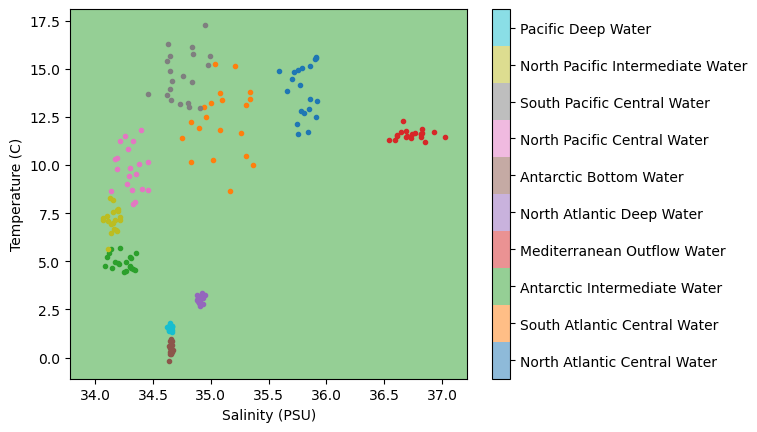

In [68]:
C = plt.pcolormesh(Salinity, Temperature, WaterMassIndices, cmap='tab10',
                   alpha=0.5, vmin=0, vmax=len(watermasses_long))
cbar = plt.colorbar(C, ticks=np.arange(len(watermasses_long))+0.5)
cbar.set_ticklabels(watermasses_long)
for w, watermass, in enumerate(watermasses):
    plt.plot(df[df['WaterMass']==watermass]['Salinity_PSU'],
             df[df['WaterMass']==watermass]['Temperature_C'],
             '.', label=watermass, color=colors[w])
plt.ylabel('Temperature (C)')
plt.xlabel('Salinity (PSU)')
plt.show()

In the above plot, we can see that we've classified the regions of our temperature-salinity space similar to the KNN example, but the results of the decision tree are a bit different. Specifically, we see that the boundaries are very "boxy" - and this isn't suprising because these regions are determined by a binary split based on two parameters. In practice, you would want to visualized your overall results with a few different classifiers and determine which approach is best suited to your example based on your domain-specific knowledge.

### Determining Splits

In the above example, we could clearly see that the MOW water mass, for example, is distinguished by a salinity of about 36.24 psu. But how exactly are these types of divisions determined in general? If we hope to have an algorithm that does this for us for a general data set, we're going to need a way to compute where these splits should happen. For our classification problem, we'll need a metric of what's typically termed the *impurity* of a data set, and another metric for the overall *information gain* resulting from a given parameter.

#### Gini Impurity

The impurity of a data set is a quantification of the mix of different classes in the set. A data set with all values having the same classification is "pure" and a very mixed class is "impure" (in the parlence of the field...). There are a few different metrics for "impurities" but one common one is the Gini Impurity, defined for a dataset $D$ as follows:

$$
I_G(D) = 1 - \sum_{i=1}^c p(i)^2
$$

where $p(i)$ is the proportion of points belonging to class $i$. When considering the whole data set for our MOW example, this would be computed as:

$$
I_G = 1 - \left( \frac{\text{number of points classified as MOW}}{\text{total number of points}} \right)^2 - \left( \frac{\text{number of points not classified as MOW}}{\text{total number of points}} \right)^2
$$

#### Information Gain
The concept of impurities is useful in defining the information gain, defined as

$$
G(D_p, f) = I(D_p) - \sum_{i=1}^m \frac{N_i}{N_p} I(D_i)
$$

where
- $D_p$ and $D_i$ are the "parent" and "child" datasets
- $f$ is the feature used to define the division
- $I$ is the impurity metric (e.g. the Gini impurity)
- $m$ is number of nodes (2 for a binary split)
- $N_p$ and $N_i$ are the number of points in the datasets $D_p$ and $D_i$ 

When considering our MOW dataset being split at a given salinity, this would be computed as

$$
G = I_{G,total} - \left( \frac{\text{number of points classified as MOW}}{\text{total number of points}} \right)I_{G,MOW} - \left( \frac{\text{number of points not classified as MOW}}{\text{total number of points}} \right)I_{G,not MOW}
$$

Let's code up this example for our particular data set:

In [ ]:
# make a list of salt splits to explore
salt_splits = np.linspace(np.min(df['Salinity_PSU']), np.max(df['Salinity_PSU'))

# make empty arrays for the information gain and the impurities
information_gain = np.zeros_like(salt_splits)
gini_impurities = np.zeros_like(salt_splits)
gini_impurities_not_mow = np.zeros_like(salt_splits)
gini_impurities_mow = np.zeros_like(salt_splits)

# loop through each split to compute the quantities above
for s in range(len(salt_splits)):
    
    # divide the data set into two subsets based on the salt split
    

    # compute the gini impurity for the not_MOW subset
    n_not_mow = len(subset_not_MOW)
    n_not_mow_in_not_mow = (subset_not_MOW['WaterMassIndex'] != 3).sum()
    n_mow_in_not_mow = (subset_not_MOW['WaterMassIndex'] == 3).sum()
    I_not_MOW = 1
    if n_not_mow>0:
        I_not_MOW -= ((n_not_mow_in_not_mow/n_not_mow))**2
        I_not_MOW -= ((n_mow_in_not_mow/n_not_mow))**2
    gini_impurities_not_mow[s] = I_not_MOW

    # compute the gini impurity for the MOW subset
    n_mow = len(subset_MOW)
    n_not_mow_in_mow = (subset_MOW['WaterMassIndex'] != 3).sum()
    n_mow_in_mow = (subset_MOW['WaterMassIndex'] == 3).sum()
    I_MOW = 1
    if n_mow>0:
        I_MOW -= ((n_not_mow_in_mow/n_mow))**2
        I_MOW -= ((n_mow_in_mow/n_mow))**2
    gini_impurities_mow[s] = I_MOW

    # compute the gini impurity for the whole dataset
    n = len(df)
    n_not_mow = (df['WaterMassIndex'] != 3).sum()
    n_mow = (df['WaterMassIndex'] == 3).sum()
    I = 1 - (n_mow/n)**2 - (n_not_mow/n)**2
    gini_impurities[s] = I

    # compute the information gain
    IG = 
    information_gain[s] = 

With this information in hand, let's see how the quantities compare across our salinity space:

In [ ]:
plt.subplot(2,1,1)
plt.plot(salt_splits, gini_impurities_not_mow, label='Not MOW')
plt.plot(salt_splits, gini_impurities_mow, label='MOW')
plt.plot(salt_splits, gini_impurities, label='All')
plt.ylabel('Gini Impurity')
plt.grid(linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(2,1,2)
plt.plot(salt_splits, information_gain)
plt.grid(linestyle='--', linewidth=0.5)
plt.ylabel('Information Gain')
plt.xlabel('Salinity (psu)')
plt.show()

As we can see in the plot above, the information gain is at its maximum when the salinity used to split the data set separates all of the points into the proper categories - i.e. the MOW subset only contains MOW points, and the not MOW set does not contain any MOW points. In this case, both subsets have a Gini Impurity of 0.

## Back to the problem at hand

We've just done a lot of work to build some classifiers for our data, and it's always helpful to remind ourselves what we were trying to accomplish. At the start, we wanted to determine where water masses were moving in the ocean. Let's have a look at that on our transects. Let's use our models to compute classifications of the entire salintiy and temperature grids provided:

In [ ]:
# normalize the salinity and temperature grids


# estimate the water mass classifications using the KNN classifier


# estimate the water mass classifications using the DT classifier


In [ ]:
l42.plot_classification_crosssection(latitude, Z, depth, WaterMassIndices_knn, WaterMassIndices_dt, watermasses_long)    

**Key Takeaways**
1. $k$-Nearest Neighbor and Decision Tree classifiers are capable of assigning classification in non-linear regions of the feature space.
2. Both classifiers are based on simple rules guided by the available data and their classifications.
3. The `scikit-learn` package has an implementation for different types of machine learning tools.